In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [2]:
h1_df = pd.read_csv('data/H1.csv')

In [3]:
h1_df.shape

(40060, 31)

In [4]:
h1_df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
time_series_h1 = h1_df.groupby(['ArrivalDateYear', 'ArrivalDateWeekNumber']).agg(
    count_total=('IsCanceled', 'count'),
    count_canceled=('IsCanceled', 'sum'),
    percent_canceled=('IsCanceled', 'mean')).reset_index()

In [6]:
time_series_h1.head()

,ArrivalDateYear,ArrivalDateWeekNumber,count_total,count_canceled,percent_canceled
0,2015,27,177,41,0.231638
1,2015,28,271,48,0.177122
2,2015,29,341,87,0.255132
3,2015,30,317,74,0.233438
4,2015,31,347,101,0.291066


In [7]:
time_series_h1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ArrivalDateYear        115 non-null    int64  
 1   ArrivalDateWeekNumber  115 non-null    int64  
 2   count_total            115 non-null    int64  
 3   count_canceled         115 non-null    int64  
 4   percent_canceled       115 non-null    float64
dtypes: float64(1), int64(4)
memory usage: 4.6 KB


In [8]:
time_series_h1['ArrivalDate'] = time_series_h1.apply(lambda x: datetime.strptime('%dW%d Mon' % (x.ArrivalDateYear, x.ArrivalDateWeekNumber),
                                                                                 '%YW%U %a'), axis=1)

In [9]:
time_series_h1.head()

,ArrivalDateYear,ArrivalDateWeekNumber,count_total,count_canceled,percent_canceled,ArrivalDate
0,2015,27,177,41,0.231638,2015-07-06
1,2015,28,271,48,0.177122,2015-07-13
2,2015,29,341,87,0.255132,2015-07-20
3,2015,30,317,74,0.233438,2015-07-27
4,2015,31,347,101,0.291066,2015-08-03


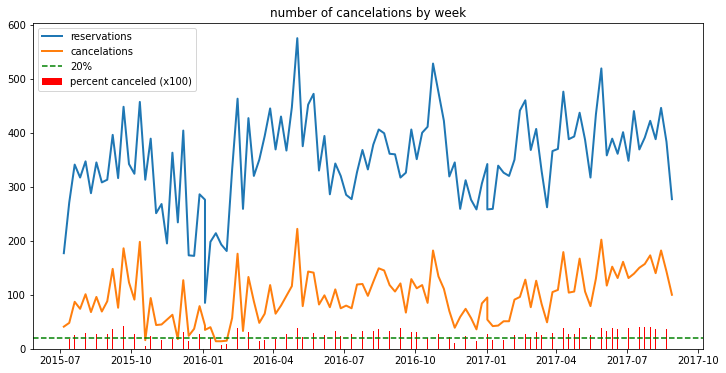

In [10]:
# plt.plot()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(time_series_h1['ArrivalDate'], time_series_h1['count_total'], lw=2, label="reservations")
ax.plot(time_series_h1['ArrivalDate'], time_series_h1['count_canceled'], lw=2, label="cancelations")
ax.bar(time_series_h1['ArrivalDate'], time_series_h1['percent_canceled'] * 100, lw=2, color='r', label="percent canceled (x100)")
ax.axhline(20, color='g', linestyle="--", label='20%')
year_loc = mdates.MonthLocator(interval=3)
year_fmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_locator(year_loc)
ax.xaxis.set_major_formatter(year_fmt)
plt.legend()
plt.title('number of cancelations by week');

In [11]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

In [12]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=53, observed_time_series=observed_time_series)
  model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
  return model

In [14]:
time_series_h1['count_canceled'] = time_series_h1['count_canceled'].astype(np.float32)

In [15]:
cancellation_model = build_model(time_series_h1['count_canceled']) # co2_by_month_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=cancellation_model)

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


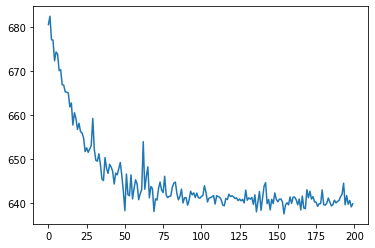

In [18]:
#@title Minimize the variational loss.

train_data = time_series_h1['count_canceled']

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=cancellation_model.joint_log_prob(
        observed_time_series=train_data),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_co2_ = variational_posteriors.sample(50)